<a href="https://colab.research.google.com/github/acadmaniac/CircuitSchematicImageInterpreter/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install Google Cloud Storage library
!pip install --upgrade google-cloud-storage


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0


In [ ]:
from google.cloud import storage

# Initialize GCS client
client = storage.Client()
bucket_name = 'acadmaniac-material'
bucket = client.bucket(bucket_name)

In [ ]:
import os

# Create a directory to store images
os.makedirs('images', exist_ok=True)

# List blobs in the GCS bucket
blobs = bucket.list_blobs(prefix='sheets/')

# Download images
for blob in blobs:
    if blob.name.endswith('.jpg'):  # Assuming images are .jpg files
        blob.download_to_filename(os.path.join('images', os.path.basename(blob.name)))

In [ ]:
import json

# Load annotations from the JSONL file
annotations = []
with open('annotations.jsonl', 'r') as f:
    for line in f:
        annotations.append(json.loads(line))

In [ ]:
os.makedirs('labels', exist_ok=True)

In [8]:
from PIL import Image

# Load annotations
annotations_dict = {}
with open('annotations.jsonl', 'r') as f:
    for line in f:
        item = json.loads(line)
        image_uri = item['imageGcsUri']
        image_name = os.path.basename(image_uri)
        image_base, _ = os.path.splitext(image_name)
        annotations_dict[image_base] = item.get('boundingBoxAnnotations', [])

# Get list of all images
image_files = os.listdir('images')
image_bases = [os.path.splitext(f)[0] for f in image_files]

# Create labels directory
os.makedirs('labels', exist_ok=True)

# Process each image
for image_name in image_files:
    image_base, _ = os.path.splitext(image_name)
    image_path = os.path.join('images', image_name)

    # Load image to get dimensions
    try:
        image = Image.open(image_path)
        width, height = image.size
    except FileNotFoundError:
        print(f"Image {image_name} not found.")
        continue

    # Open corresponding label file
    label_file_path = os.path.join('labels', f"{image_base}.txt")
    with open(label_file_path, 'w') as label_file:
        if image_base in annotations_dict and annotations_dict[image_base]:
            # Write annotations
            for bbox in annotations_dict[image_base]:
                class_id = 0  # Assuming 'Diagram' is the only class

                # Extract normalized coordinates
                x_min = bbox['xMin']
                x_max = bbox['xMax']
                y_min = bbox['yMin']
                y_max = bbox['yMax']

                # If coordinates are not normalized, normalize them
                # x_min /= width
                # x_max /= width
                # y_min /= height
                # y_max /= height

                # Calculate YOLO format values
                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                bbox_width = x_max - x_min
                bbox_height = y_max - y_min

                # Write to label file
                label_file.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")
        else:
            # No annotations for this image; create an empty label file
            pass  # Empty label file indicates no objects


In [ ]:
import shutil

# Create directories
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)

In [9]:
import glob
import shutil
from sklearn.model_selection import train_test_split

# Get list of images and labels
image_files = glob.glob('images/*.jpg')
image_basenames = [os.path.basename(f) for f in image_files]

# Split data
train_images, val_images = train_test_split(image_basenames, test_size=0.2, random_state=42)

# Function to copy images and labels
def copy_data(image_list, image_dest, label_dest):
    for image_name in image_list:
        # Copy image
        shutil.copy(os.path.join('images', image_name), image_dest)
        # Copy label file
        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_src = os.path.join('labels', label_name)
        label_dst = os.path.join(label_dest, label_name)
        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)
        else:
            # Create an empty label file if it doesn't exist
            with open(label_dst, 'w') as f:
                pass

# Copy training data
copy_data(train_images, 'dataset/images/train/', 'dataset/labels/train/')

# Copy validation data
copy_data(val_images, 'dataset/images/val/', 'dataset/labels/val/')


In [10]:
data_yaml = """
train: dataset/images/train
val: dataset/images/val

nc: 1
names: ['Diagram']
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml)

In [11]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 46.7 MB/s eta 0:00:00


In [34]:
from ultralytics import YOLO

# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolo11s.pt")

# Train the model using the 'data.yaml' dataset for 100 epochs
results = model.train(data="data.yaml", epochs=100, imgsz=640)

100%|██████████| 18.4M/18.4M [00:00<00:00, 248MB/s]


Ultralytics 8.3.20 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

wandb: Currently logged in as: acadmaniacofficial (acadmaniacofficial-acadmaniac). Use `wandb login --relogin` to force relogin


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/datasets/dataset/labels/train.cache... 385 images, 60 backgrounds, 0 corrupt: 100%|██████████| 385/385 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/datasets/dataset/images/train/Adobe Scan 21 Oct 2024_page-0041.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/datasets/dataset/images/train/Adobe Scan 21 Oct 2024_page-0045.jpg: 4 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/dataset/labels/val.cache... 97 images, 12 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/dataset/images/val/Adobe Scan 21 Oct 2024_page-0017.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/dataset/images/val/E-Sheet - (GO)_With solution_page-0210.jpg: 2 duplicate labels removed


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.43G      1.396      4.455      1.434          1        640: 100%|██████████| 25/25 [00:04<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all         97        162      0.736      0.602      0.589      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.34G      1.058       1.43      1.137          6        640: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]


                   all         97        162      0.425      0.703      0.564      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.41G      1.108      1.123      1.181          5        640: 100%|██████████| 25/25 [00:03<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all         97        162     0.0606     0.0741       0.03     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.37G      1.194       1.09      1.242          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

                   all         97        162     0.0606     0.0741       0.03     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.35G      1.165      1.044      1.221          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.10it/s]

                   all         97        162   0.000105    0.00617    5.3e-05   1.06e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.39G      1.103     0.9534      1.206          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


                   all         97        162      0.222     0.0864     0.0468     0.0263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       4.4G      1.006     0.9155       1.13          0        640: 100%|██████████| 25/25 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]

                   all         97        162      0.427       0.16      0.144     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.39G      1.117     0.8943       1.21         11        640: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


                   all         97        162      0.594      0.722      0.685      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.34G       1.08     0.9145      1.203          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]

                   all         97        162      0.721      0.767      0.722      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.41G      0.952     0.8395      1.107          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.52it/s]


                   all         97        162      0.656      0.647      0.678      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.37G     0.9935     0.7948      1.124          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]

                   all         97        162      0.888      0.785      0.868      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.37G      1.015     0.7931       1.16          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

                   all         97        162      0.852      0.716      0.784      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.35G      1.066     0.8742      1.182          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

                   all         97        162      0.781      0.506       0.59      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.41G     0.9492     0.7545      1.106          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]

                   all         97        162      0.481      0.432      0.375      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       4.4G       0.98     0.8252      1.148          3        640: 100%|██████████| 25/25 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.02it/s]

                   all         97        162      0.814      0.754      0.806      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       4.4G     0.8895     0.9094      1.033          0        640: 100%|██████████| 25/25 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

                   all         97        162      0.807      0.799      0.825      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.36G      0.914     0.7804      1.098          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.25it/s]

                   all         97        162      0.376      0.253       0.19     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.38G     0.9124     0.8358      1.094          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

                   all         97        162      0.833      0.698      0.837      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       4.4G     0.9001     0.6868      1.094          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

                   all         97        162       0.87      0.778      0.863      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.37G     0.9212      0.715      1.086          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all         97        162      0.449       0.29      0.251     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.33G     0.9528     0.6933      1.101          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.08it/s]

                   all         97        162      0.892      0.877      0.898      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.38G     0.9195     0.6981      1.077          6        640: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]

                   all         97        162      0.857      0.742      0.793      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.37G     0.8497      1.087      1.039          0        640: 100%|██████████| 25/25 [00:03<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.38it/s]

                   all         97        162      0.748      0.695      0.782      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       4.4G     0.8499     0.7267      1.078          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

                   all         97        162      0.863      0.833      0.873      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.36G     0.8317     0.6665       1.05          6        640: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]

                   all         97        162       0.86      0.827      0.869      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.39G     0.7902      0.601      1.025         10        640: 100%|██████████| 25/25 [00:03<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.15it/s]

                   all         97        162       0.87      0.833      0.889      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.39G     0.7887     0.5971      1.027          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.23it/s]

                   all         97        162      0.925      0.839      0.911      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.37G     0.8055     0.6183      1.043          6        640: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

                   all         97        162      0.889       0.79      0.882      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.33G     0.7807     0.6718     0.9933          0        640: 100%|██████████| 25/25 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all         97        162      0.864      0.858      0.909      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.39G     0.8406     0.6562      1.062          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.04it/s]

                   all         97        162      0.877       0.75      0.872      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       4.4G     0.7619     0.5632      1.001          7        640: 100%|██████████| 25/25 [00:03<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

                   all         97        162      0.851      0.846      0.886       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       4.4G     0.7922     0.6962      1.038          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

                   all         97        162      0.889      0.794      0.893      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.34G     0.7669     0.5546      1.017          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]

                   all         97        162      0.871      0.883      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.43G     0.7709     0.5562      1.017          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.14it/s]

                   all         97        162      0.905      0.827      0.912      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       4.4G     0.7624     0.5345      1.009          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

                   all         97        162      0.866      0.756      0.838      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.39G     0.7695     0.5526     0.9995          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all         97        162      0.869      0.863       0.87      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.38G     0.7672     0.5773      1.021          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

                   all         97        162      0.867      0.772      0.864      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.38G     0.7307     0.5266      0.996          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]

                   all         97        162      0.875      0.863      0.891      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.39G     0.7173     0.5868     0.9622          0        640: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

                   all         97        162      0.901      0.895      0.932      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.37G     0.7975     0.5937      1.056          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

                   all         97        162      0.878      0.846       0.91       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.35G     0.7346     0.5305      1.006          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all         97        162      0.948      0.765      0.869      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.39G       0.71     0.4907     0.9902          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.18it/s]

                   all         97        162      0.946       0.87      0.942      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.37G     0.6385     0.4654     0.9307          0        640: 100%|██████████| 25/25 [00:03<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]

                   all         97        162      0.917      0.784      0.857      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.37G     0.7079     0.5024     0.9732          7        640: 100%|██████████| 25/25 [00:03<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]

                   all         97        162      0.904      0.818      0.887      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.38G     0.7167     0.5166     0.9863          7        640: 100%|██████████| 25/25 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all         97        162      0.933      0.877      0.914      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.39G      0.726     0.5223      1.004          6        640: 100%|██████████| 25/25 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

                   all         97        162      0.899      0.825      0.838      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       4.4G     0.6763     0.4798     0.9555          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

                   all         97        162      0.926      0.864      0.905      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.37G     0.6729     0.4741     0.9652          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

                   all         97        162      0.918      0.827      0.914      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.34G     0.6479     0.5302     0.9299          0        640: 100%|██████████| 25/25 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]

                   all         97        162      0.925      0.834      0.903      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       4.4G     0.6764     0.4701     0.9564          2        640: 100%|██████████| 25/25 [00:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]

                   all         97        162      0.946      0.874      0.927      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       4.4G     0.6559     0.4726     0.9523          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all         97        162      0.956      0.808      0.903       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       4.4G     0.6659     0.5026     0.9826          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

                   all         97        162      0.874      0.907      0.922       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.35G     0.6512     0.4625     0.9564          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all         97        162      0.919      0.845      0.894      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.39G     0.6622     0.4617     0.9667          8        640: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.42it/s]

                   all         97        162      0.933      0.907       0.91      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.38G     0.6696     0.4682      1.024          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]

                   all         97        162      0.915      0.869      0.934      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.37G     0.6618     0.4851     0.9686          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.27it/s]

                   all         97        162      0.945      0.864      0.939      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.37G     0.6537     0.4654     0.9514          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

                   all         97        162       0.85      0.864      0.895       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.41G     0.6807     0.4872     0.9751          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]

                   all         97        162      0.876      0.907      0.928      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.39G     0.6604     0.4718     0.9534          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

                   all         97        162      0.854      0.809      0.878      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.37G     0.6439     0.4592     0.9509          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.38it/s]

                   all         97        162      0.912      0.827       0.91      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.35G     0.6264     0.4792     0.9553          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

                   all         97        162      0.905      0.878      0.927      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.41G     0.6483     0.4787     0.9619          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all         97        162      0.889      0.901      0.937      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.38G     0.6158     0.4442     0.9366          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all         97        162      0.903      0.916      0.938      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       4.4G     0.6225     0.4433     0.9313          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.22it/s]


                   all         97        162       0.93       0.87      0.929      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.35G     0.6329     0.5749     0.9932          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

                   all         97        162       0.92       0.87      0.927       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       4.4G     0.6023     0.4258     0.9519          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

                   all         97        162      0.936      0.895      0.926      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.39G     0.6006     0.4258     0.9486          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all         97        162      0.928      0.876      0.927      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.39G     0.6069     0.4114     0.9445          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]

                   all         97        162      0.916      0.889      0.933       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.34G     0.6014     0.4229      0.928          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.92it/s]

                   all         97        162        0.9      0.831      0.882      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       4.4G     0.6109     0.4297      0.938          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all         97        162       0.91      0.852      0.915      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       4.4G      0.614     0.4262     0.9328          7        640: 100%|██████████| 25/25 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.17it/s]

                   all         97        162      0.905      0.886      0.911      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.37G     0.5843     0.4074     0.9225          2        640: 100%|██████████| 25/25 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.14it/s]

                   all         97        162      0.951      0.838      0.917      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.36G     0.5807      0.436     0.9383          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

                   all         97        162      0.918      0.897      0.932      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       4.4G     0.5915     0.4161     0.9316          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.35it/s]

                   all         97        162      0.938      0.883      0.938      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.37G     0.5688     0.4006     0.9225          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

                   all         97        162      0.902      0.914      0.951      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.39G     0.5753     0.4197     0.9464          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


                   all         97        162      0.941      0.893      0.957      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.36G     0.5893     0.4089     0.9304          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.64it/s]

                   all         97        162      0.928       0.92      0.954      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.39G     0.6073     0.4099     0.9343          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

                   all         97        162      0.944      0.883      0.941       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       4.4G     0.5725     0.3818     0.9169          7        640: 100%|██████████| 25/25 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all         97        162      0.898      0.907       0.94      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.37G     0.5674     0.3978     0.9244          6        640: 100%|██████████| 25/25 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all         97        162      0.928      0.907      0.935      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.35G     0.5912     0.3736     0.9279          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

                   all         97        162      0.918      0.889      0.943      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       4.4G     0.5463     0.3629     0.9081          5        640: 100%|██████████| 25/25 [00:03<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]

                   all         97        162      0.904      0.889      0.937      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.37G     0.5427      0.375     0.9139          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all         97        162      0.907      0.899      0.931      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.37G     0.5352     0.3814     0.8968          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all         97        162      0.929      0.907      0.942      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.35G     0.5747      0.421     0.9304          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]

                   all         97        162      0.911      0.926      0.949      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.38G     0.5612     0.3815     0.9125          4        640: 100%|██████████| 25/25 [00:03<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.30it/s]

                   all         97        162      0.926      0.877      0.937      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       4.4G     0.5153     0.3432      0.899          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]

                   all         97        162      0.948        0.9      0.949      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.37G     0.5243     0.3672     0.9082          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.67it/s]

                   all         97        162      0.921      0.901      0.947      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.36G     0.5275     0.3818     0.9157          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.67it/s]

                   all         97        162      0.935      0.893       0.95      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       4.4G     0.5402      0.361     0.9242          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.15it/s]

                   all         97        162      0.936      0.903      0.952      0.811


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.37G     0.4421     0.3055     0.8529          2        640: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

                   all         97        162      0.929      0.907       0.94      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.37G     0.4344     0.2861     0.8581          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

                   all         97        162      0.924      0.907      0.931      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.35G     0.4184     0.2765     0.8442          3        640: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.07it/s]

                   all         97        162      0.921      0.895      0.939      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       4.4G      0.439     0.2809     0.8579          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]

                   all         97        162       0.91      0.889       0.94      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.37G     0.4201     0.2683     0.8546          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]

                   all         97        162      0.918      0.914      0.948      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.37G     0.4061     0.2679     0.8445          1        640: 100%|██████████| 25/25 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

                   all         97        162       0.92       0.92      0.952      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.35G     0.4314     0.2665     0.8315          2        640: 100%|██████████| 25/25 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.99it/s]

                   all         97        162       0.93      0.903      0.953      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.41G     0.3955      0.308     0.8341          6        640: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.32it/s]

                   all         97        162      0.918       0.92      0.949       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.37G     0.3941     0.2545     0.8398          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.21it/s]

                   all         97        162      0.925       0.92       0.95      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.37G     0.4269     0.2659     0.8536          1        640: 100%|██████████| 25/25 [00:03<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.29it/s]

                   all         97        162      0.923       0.92      0.944      0.816



100 epochs completed in 0.165 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.20 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


                   all         97        162      0.925       0.92      0.954       0.83
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▄██▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
lr/pg1,████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
lr/pg2,█████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▅▁▁▆▇▄▂▇▇▇█▇▇██▇▇███▇██████▇████████████
metrics/mAP50-95(B),▁▁▅▃▅▆▇▇▆▆▇▇▇▆▇▇▇▇▇▇▇█▇▇█▇█▇▇███████████
metrics/precision(B),▄▁▁▄▅█▇▇▄▇█▇▇▇▇███████▇█████████████████
metrics/recall(B),▅▁▁▂▆▆▅▄▇▆▇▇▇▇▇█▇▇█▇▇▇▇█████▇▇██████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁


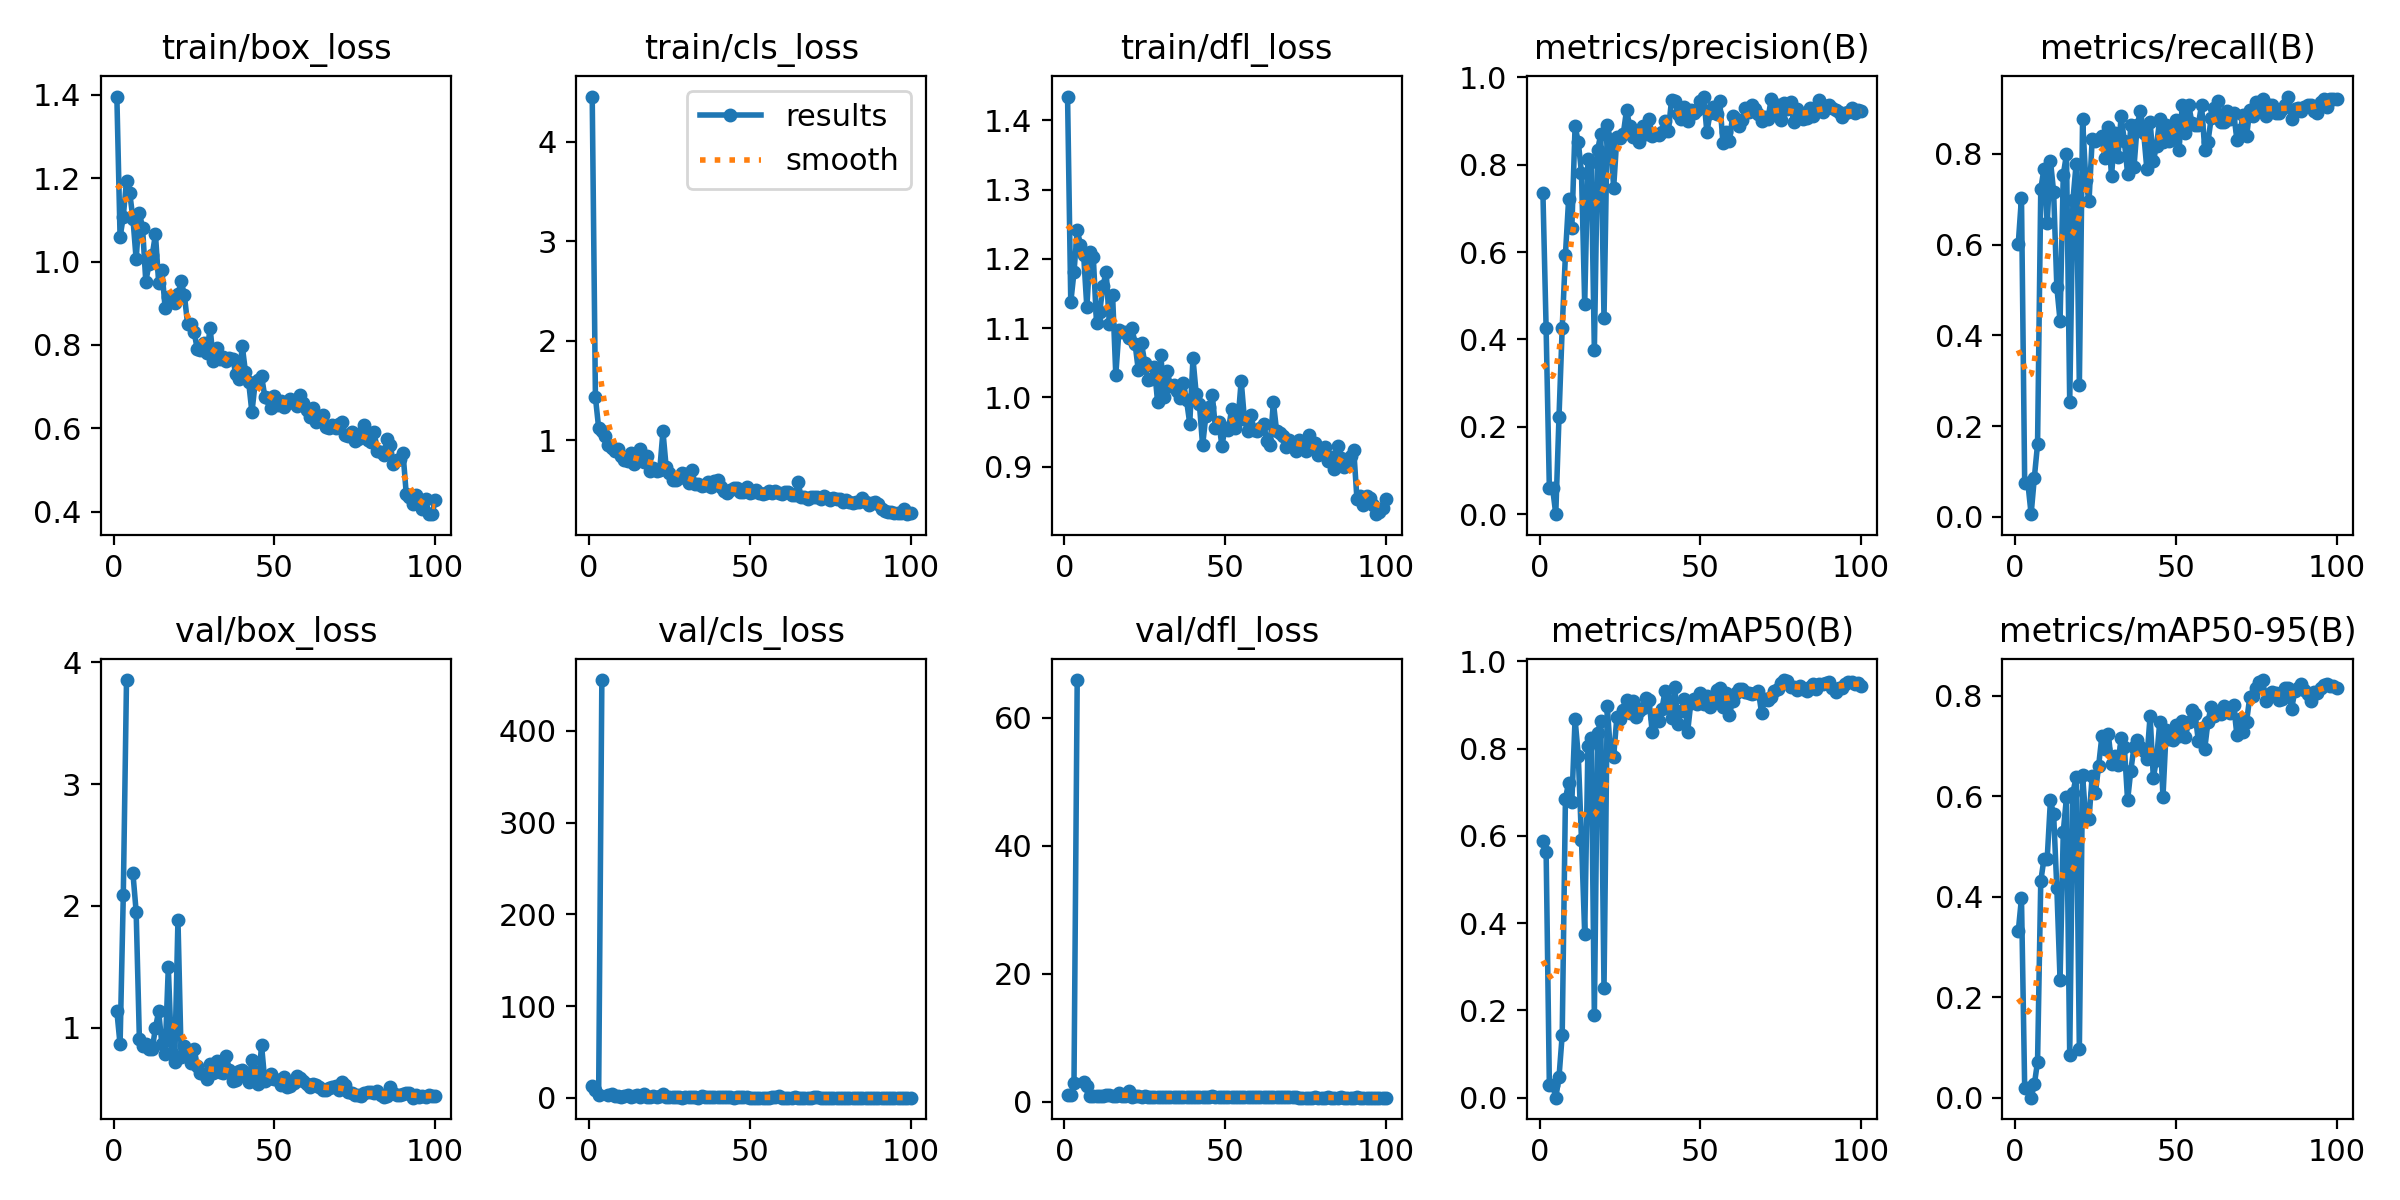

In [35]:
from IPython.display import Image, display

# Display training results
display(Image(filename='runs/detect/train/results.png'))

In [36]:
import locale
import os

def set_utf8_locale():
  """Sets the locale to UTF-8."""
  # Try setting the locale to en_US.UTF-8
  try:
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
    return
  except locale.Error:
    pass

  # Try setting the locale to C.UTF-8
  try:
    locale.setlocale(locale.LC_ALL, 'C.UTF-8')
    return
  except locale.Error:
    pass

  # If both fail, print a warning
  print("Warning: Could not set locale to UTF-8. Some functionalities may not work properly.")


# Call the function to set the locale
set_utf8_locale()

# Run inference on validation images
os.makedirs('predictions', exist_ok=True) # Use os.makedirs instead of shell command
model.val(data='data.yaml', save_txt=True, save_conf=True, save_json=True)

Ultralytics 8.3.20 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/datasets/dataset/labels/val.cache... 97 images, 12 backgrounds, 0 corrupt: 100%|██████████| 97/97 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/datasets/dataset/images/val/Adobe Scan 21 Oct 2024_page-0017.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/dataset/images/val/E-Sheet - (GO)_With solution_page-0210.jpg: 2 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


                   all         97        162      0.928       0.92      0.955      0.831
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Saving runs/detect/train2/predictions.json...
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79e0d1eeb1c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


0: 384x640 1 Diagram, 34.9ms
Speed: 2.3ms preprocess, 34.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Diagram detected with confidence 0.90 at coordinates (151.12831115722656, 229.48988342285156, 445.287841796875, 374.67059326171875)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Diagram'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 

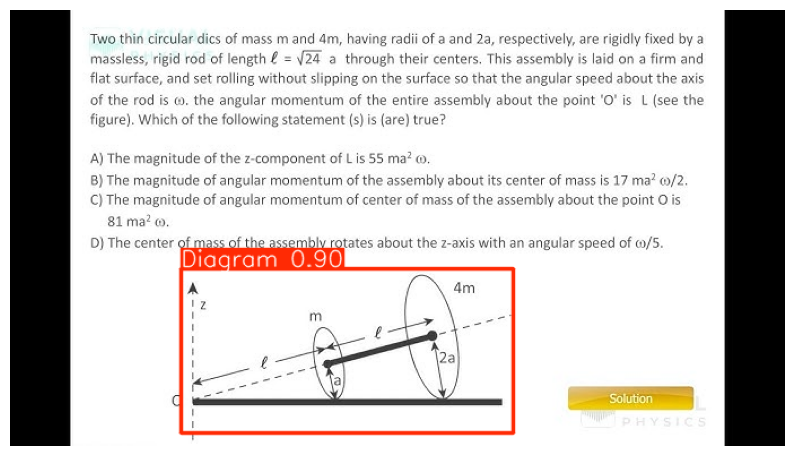

In [41]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import requests
import cv2
import numpy as np

# Load the YOLOv8 model
model = YOLO('del/detect/train4/weights/best.pt')  # Update the path accordingly

# URL of the image
image_url = "https://i.ytimg.com/vi/u_24ZIJj7MI/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLDIJSEaGEJzaGXADnF7RHNTtx-OjQ"

# Download the image from the URL
image_response = requests.get(image_url)
image_array = np.asarray(bytearray(image_response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Perform inference
results = model(image)

for result in results:
    boxes = result.boxes  # Get detected bounding boxes

    for box in boxes:
        class_id = int(box.cls[0])  # Get class ID
        if class_id == 0:  # Assuming "Diagram" is the only class, and its ID is 0
            # Process and display diagram detection
            x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
            confidence = box.conf[0].cpu().numpy()
            print(f"Diagram detected with confidence {confidence:.2f} at coordinates ({x_min}, {y_min}, {x_max}, {y_max})")


# Convert BGR image (used by OpenCV) to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(results)

# Plot the image with predictions
annotated_image = results[0].plot()  # Plot the predictions on the image
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()


In [ ]:
# Export to ONNX format
model.export(format='onnx')

# Export to TorchScript format
model.export(format='torchscript')

In [21]:
import os

train_path = os.path.abspath('dataset/images/train')
val_path = os.path.abspath('dataset/images/val')

print(f"Train Path: {train_path}")
print(f"Validation Path: {val_path}")


Train Path: /content/dataset/images/train
Validation Path: /content/dataset/images/val


In [22]:
data_yaml = f"""
train: dataset/images/train
val: dataset/images/val

nc: 1
names: ['Diagram']
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml)
